## Intro

This assignment implements from scratch:
*   (L2 and L1 regularized) linear regression
*   binary classification using logistic regression
*   (single and multitask) dense neural networks

These models are applied to the [Genomics of Drug Sensitivity in Cancer](https://www.cancerrxgene.org/) data, where almost a thousand cancer cell lines were screened against 266 drugs.

## Notes on Colab

Some useful things to know about Colab:
* You can get docs on a function with `?function`
* If an error happens, executing `%debug` will put you into `pdb`, the Python debugger (type `exit` to exit).
* If you disconnect (this includes Reloading the page!) you'll lose the instance you're on. 😞
* There's version history like Google docs under `File` -> `Revision History`.



## Setup

Before you do anything else go to the "Runtime" menu -> "Change runtime type" and choose "GPU". The following assertion should then pass:

In [2]:
import torch
assert(torch.cuda.is_available())
device = "cuda"

I've put some preprocessed data in Google Drive. To use this you need to mount your Google Drive (annoyingly you'll need to explicitly give Colab access). Be sure to use your Columbia google account (please email me if you don't have one letting me know what Google account to use instead).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

First let's load the gene expression data. We'll use `pandas` to read the data in and take a look at it. *Note you may need to adjust the file path below* (the `Files` tab on the left hand edge of the Colab notebook should help, the Assignment directory might end up in `Shared drives`). Alternatively you can try go to the Assignment 1 gdrive directory, click on "Assignment 1" and then do "Add shortcut to drive" to have it show up in "My Drive".

In [4]:
import pandas as pd
from pathlib import Path

path_to_assigment_dir = Path("/content/drive/MyDrive/Assignment 1")

express_all = pd.read_csv(path_to_assigment_dir / "Copy of Cell_line_RMA_proc_basalExp.txt.zip", sep = "\t")
express_all.iloc[:6,:8]

,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792
0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533
1,TNMD,tenomodulin [Source:HGNC Symbol;Acc:17757],2.964585,2.777716,2.643508,2.817923,2.957739,2.889677
2,DPM1,dolichyl-phosphate mannosyltransferase polypep...,10.379553,11.807341,9.880733,9.883471,10.418840,9.773987
3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903
4,C1orf112,chromosome 1 open reading frame 112 [Source:HG...,3.380681,3.732485,3.236620,3.558414,3.840373,3.815055
5,FGR,Gardner-Rasheed feline sarcoma viral (v-fgr) o...,3.324692,3.152404,3.241246,3.101247,3.001802,3.298915


The two columns are the gene symbol and gene name. The remaining columns are the expression values for each cell line. The column name is "DATA." followed by the "COSMIC ID", a unique identifier for each cell line.

Next we'll load the drug screen data.

In [5]:
ic50_all = pd.read_csv(path_to_assigment_dir / "Copy of TableS4A_ic50.txt.gz", sep = "\t", index_col = 0)
ic50_all.iloc[:6,:8]

,cell_line,TL-2-105,TAK-715,CP466722,BMS-345541,Genentech Cpd 10,GSK429286A,Ruxolitinib
cosmic_id,,,,,,,,
910944,ALL-PO,1.41,2.11,-0.76,1.39,-1.40,3.68,3.08
1295741,AMO-1,3.36,3.05,1.72,2.19,1.54,3.54,2.99
910692,COLO-668,3.40,3.10,3.07,1.23,0.31,3.57,3.73
1297439,COR-L95,3.31,6.10,2.95,2.85,3.74,5.22,3.72
906838,DG-75,3.65,3.11,2.18,1.59,2.44,5.30,4.15
753555,EC-GI-10,5.00,4.00,5.45,3.37,5.00,5.67,4.33


The index is set to be the cosmic_id. The first column is the cell line name. The remaining columns are "IC50"s for each cell line, i.e. the concentration of drug required to inhibit growth by 50%.

## Data munging

We need to do a little data munging: get the common cell lines between the two DataFrame and get the ordering the same.

In [6]:
common_cell_lines = ["DATA.%i" % g for g in ic50_all.index]
common_cell_lines = list(set(common_cell_lines).intersection( express_all.columns.tolist() ))
common_cell_lines = sorted(common_cell_lines) # required for reproducibility, set order is undefined
expression = express_all[common_cell_lines]
expression.shape

(17737, 962)

In [7]:
cosmic_ids = [int(g[5:]) for g in common_cell_lines]
ic50 = ic50_all.loc[cosmic_ids,:]
ic50.shape

(962, 266)

Keep in mind that 18% of the IC50s are missing:

In [8]:
import numpy as np
np.isnan(ic50.iloc[:,1:]).mean().mean()

0.1836661044208214

For now we'll focus on just one drug: PFI-1, an inhibitor of two related genes BRD2 and BRD4. The IC50 values will be our `y` and gene expression measurements will be our `X`. We'll do as much as possible in `pytorch` to utilize Colab's GPU.

We'll filter for non-missing IC50, and normalize both `y` and columns of `X` to have 0 mean and variance 1 ("Z-transform").

In [9]:
y_all = ic50["PFI-1"]
is_missing = np.isnan(y_all) # nan values = missing
y_unnorm = torch.tensor(y_all[~is_missing].to_numpy(), device = device, dtype = torch.float)
y = (y_unnorm - y_unnorm.mean()) / y_unnorm.std() # normalize

X_all = expression.to_numpy().transpose() # X should be [N x P]
X_unnorm = torch.tensor(X_all[~is_missing,:], device = device, dtype = torch.float)
X = (X_unnorm - X_unnorm.mean(0, keepdims=True)) / X_unnorm.std(0, keepdims=True)

## Training, validation & test split

We'll split our data into training (80%), validation (10%, for picking lambda) and test (10%, for assessing final performance). Ideally for this data size we'd use cross-validation but that would be a bit slow to wait for.

In [10]:
N = len(y)
print(N)
np.random.seed(1234) # for reproducibility
rand_perm = np.random.permutation(N)
train_idx = rand_perm[:int(np.ceil(0.8 * N))]
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))]
test_idx = rand_perm[int(np.ceil(0.9 * N)):]

X_train = X[train_idx,:]
X_val = X[val_idx,:]
X_test = X[test_idx,:]

y_train = y[train_idx]
y_val = y[val_idx]
y_test = y[test_idx]

rand_perm[:10]

916


array([746, 401,  60, 590,  40, 495, 410, 569, 282, 326])

## Ridge regression

We'll first use the analytic solution to ridge regression, which involves solving a big system of linear equations:

$ \hat{\beta} = (X^T X + N \lambda I)^{-1} X^T y $

Note here we scale $\lambda$ by $N$ (the number of samples, `X.shape[0]`) to make the choice of $\lambda$ less dependent on the sample size. We could equivalently have divided the squared error term in the loss by $N$ (indeed that's what we'll do for gradient descent below).

Your first **task** is to implement this equation in `pytorch`. [2 points]

Useful things to know:
*   `@` is used by both `numpy` and `pytorch` to denote matrix multiplication.
*   In `pytorch` you need to do `X.transpose(0,1)` for the regular matrix transpose, since it support switching other dimensions.
* The identity matrix $I$ can be made with `torch.eye`: you'll get to get the right dimension (from `X.shape`) and pass the appropriate `device`, which you can get from `X.device` (or just hardcode it if you want).
* Check the docs for `torch.linalg.solve` using `?torch.linalg.solve` which is letting us calculate `beta` entirely on the GPU:

In [11]:
?torch.linalg.solve

Note that both inputs to `torch.solve` need to be 2D: you can make `y` a `N x 1` matrix with `y[:,None]`. Also, `torch.solve` returns both the solution $A^{-1} input$ and the LU decomposition it used to do the solve - we don't need the latter so we ignore it by putting it into the dummy variable denoted by an underscore _.

In [12]:
def ridge_regression(X, y, lamb):
    A = X.transpose(0,1)@X + X.shape[0]*lamb*torch.eye(X.shape[1]).to(X.device)
    B = X.transpose(0,1)@y
    beta = torch.linalg.solve(A,B
        )
    return beta
    #return(beta[:,0]) # matrix -> vector

**`If`** you implemented it correctly, the following assertion should pass (it takes a few seconds to do the matrix solve):

In [13]:
beta = ridge_regression(X_train, y_train, lamb = 1.)
assert( np.abs(beta.std().item() - 0.0018369749886915088 ) < 1e-6 )

Let's try some different values of the regularization parameter `lambda`.

Text(0, 0.5, 'Validation RMSE')

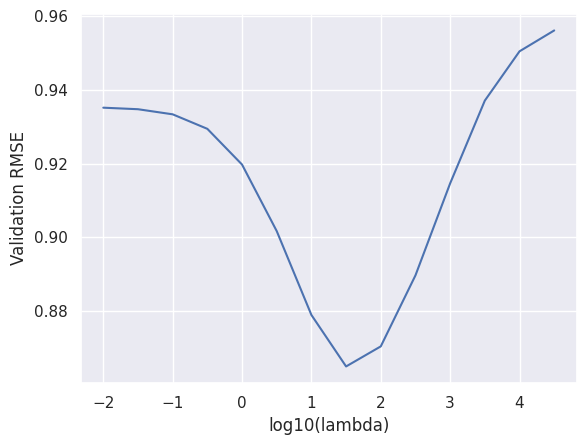

In [14]:
import matplotlib.pyplot as plt # for plotting
import seaborn as sns
sns.set() # nice default plot formatting

lambdas = 10 ** np.arange(-2, 5, step = 0.5)
val_rmse = np.zeros_like(lambdas)

for i,lamb in enumerate(lambdas): # try different settings of lambda
    beta = ridge_regression( X_train, y_train, lamb )
    pred_val = X_val @ beta # make predictions on the validation set
    val_rmse[i] = np.sqrt(torch.mean((y_val - pred_val)**2).item()) # item() gets the scalar value

plt.plot(np.log10(lambdas), val_rmse)
plt.xlabel("log10(lambda)")
plt.ylabel("Validation RMSE")

The left hand side here corresponds to overfitting the data, and the right hand side to underfitting, with the optimal `lambda` in between. We can extract the optimal `lambda` as:

In [15]:
optimal_lamb = lambdas[np.argmin(val_rmse)]
optimal_lamb

31.622776601683793

## Gradient descent for ridge regression

The other way we could fit ridge regression is using gradient descent (GD).

I've implemented the loss function, **you'll need to implement the gradient** for the loss,

$ \frac1{2N} \sum_{i=1}^N (y_i - X_i \beta)^2 + \frac{\lambda}{2} | \beta |^2_2 $

THE N HERE IS FOR THE TRAINING DATA, WHICH IS NOT THE THE N FROM THE CODE ABOVE. What is the gradient wrt $\beta$? (we did this in lecture 1 although without the $\frac1N$ factor) [1 point]

**TODO YOUR ANSWER HERE**

A correct implementation will result in the assertion passing. Note that it's possible to write the expression you need in terms of `err = y - X @ beta`, which is already calculated and therefore saves some computation. [2 points]

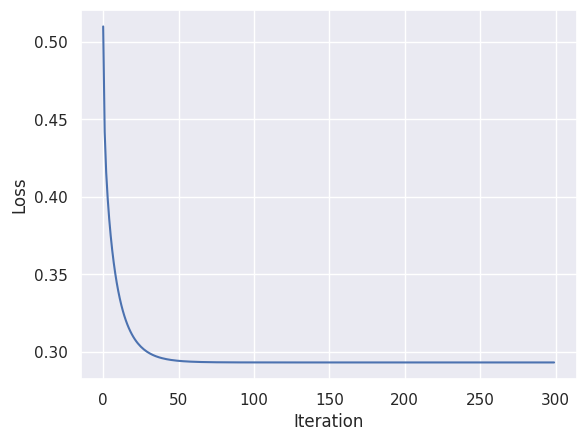

In [16]:
def ridge_regression_gd(X, y, lamb, learning_rate = 0.001, iterations = 300):
    beta = torch.zeros(X.shape[1], device=device)
    losses = []
    for k in range(iterations): # in practice we would use an appropriate "stopping criteria"
        err = y - X @ beta
        loss = .5 * (err * err).mean() + .5 * lamb * (beta * beta).sum()
        if np.isnan(loss.item()):
            print("Warning: GD diverged on iteration %i" % k)
            break
        losses.append(loss.item())
        grad = -(X.transpose(0,1))@(err)*(1/X.shape[0]) + lamb*beta
        beta -= learning_rate * grad
    return(beta,losses)

beta,losses = ridge_regression_gd(X_train, y_train, lamb = optimal_lamb)

_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")

assert( np.abs(losses[-1] - 0.2930864095687866 ) < 1e-6 )

Try playing around with the learning rate. **Find a value that's too small so that the algorithm doesn't converge in 300 iterations**: [1 point]

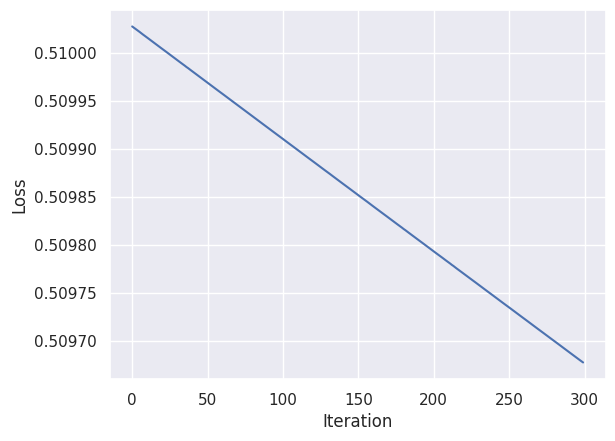

In [17]:
_,losses = ridge_regression_gd(X_train, y_train, lamb = optimal_lamb, learning_rate = 0.00000001)

_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")

[link text](https://)**Now find a learning rate that's too big so the optimization will diverge and end up giving `nan` values.** [1 point]

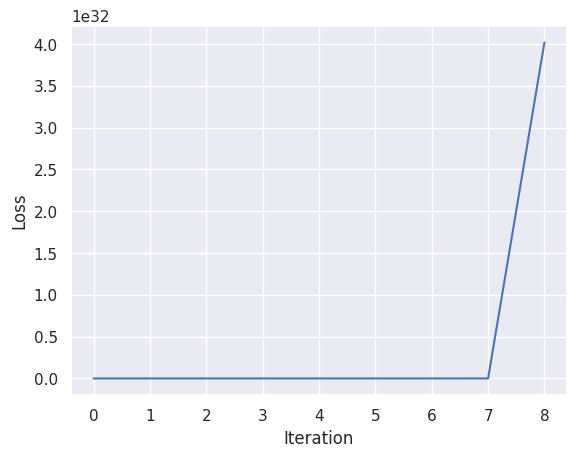

In [18]:
_,losses = ridge_regression_gd(X_train, y_train, lamb = optimal_lamb, learning_rate = 0.1)

_ = plt.plot(losses)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Loss")

Note that at at this scale with `P >> N` gradient descent is considerably faster than the matrix solve used above. Let's check we're getting the same answer with both approaches:

In [19]:
beta_analytic = ridge_regression(X_train, y_train, optimal_lamb)
(beta_analytic - beta).abs().mean().item()

1.8622671182910722e-09

The beta found by the two approaches are almost identical.

Let's take a look at the distribution of the coefficients:  

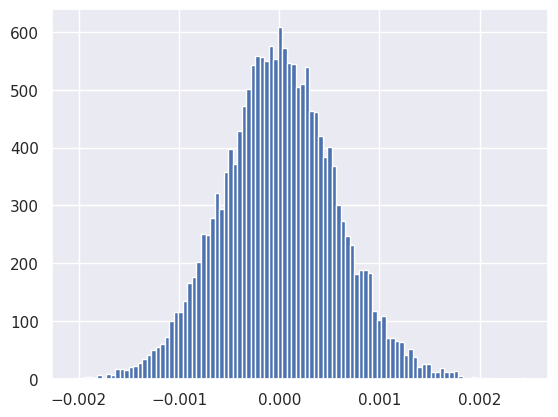

In [20]:
_ = plt.hist(beta_analytic.cpu().numpy(), 100)


These look roughly Gaussian distributed. We can look at the predictions on test data and assess how good these are using the Pearson correlation and hypothesis test (for the correlation being non-zero):  

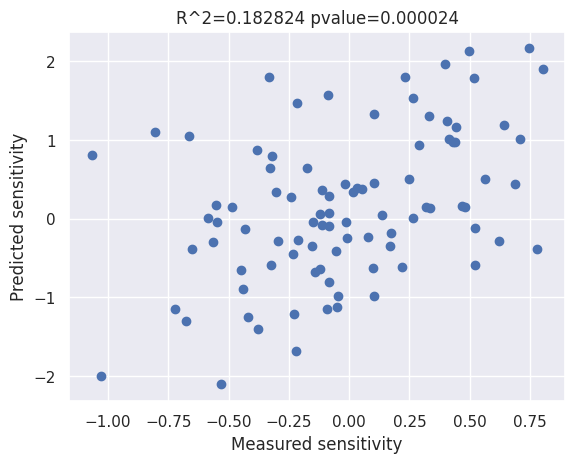

In [21]:
pred_test = X_test @ beta_analytic # make predictions on the test set
import scipy
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())
plt.scatter(pred_test.cpu(), y_test.cpu())
plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

The predicted and observed drug sensitivity measurements are significantly correlated.


## LASSO regression

We can similarly use (sub)gradient descent to fit L1 regularized regression, aka the [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)). A subgradient of $|\beta|$ is sign$(\beta)$.

Code the gradient - you hopefully already know how to implement the gradient of the squared error term, so now you just need the regularization term [1 point].

In [22]:
def fit_lasso(X, y, lamb, learning_rate = 0.001, iterations = 100):
    beta = torch.zeros(X.shape[1], device=X.device)
    losses = []
    for it in range(iterations):
        err = y - X @ beta
        loss = .5 * (err * err).mean() + lamb * beta.abs().sum()
        if np.isnan(loss.item()):
            print("Warning: GD diverged on iteration %i" % it)
            break
        losses.append(loss.item())
        grad = (-1*X.transpose(0,1) @ err)/y.shape[0] + lamb * torch.sign(beta)
        beta -= learning_rate * grad
    return(beta,losses)

beta,_ = fit_lasso(X_train, y_train, learning_rate = 0.001, lamb = 0.01, iterations = 1000)
assert( np.abs(beta.std().item() - 0.0020454663317650557 ) < 1e-6 )




Let's try a range of regularization parameters again:

Lambda=0.000001, fitting...
Lambda=0.000010, fitting...
Lambda=0.000100, fitting...
Lambda=0.001000, fitting...
Lambda=0.010000, fitting...
Lambda=0.100000, fitting...


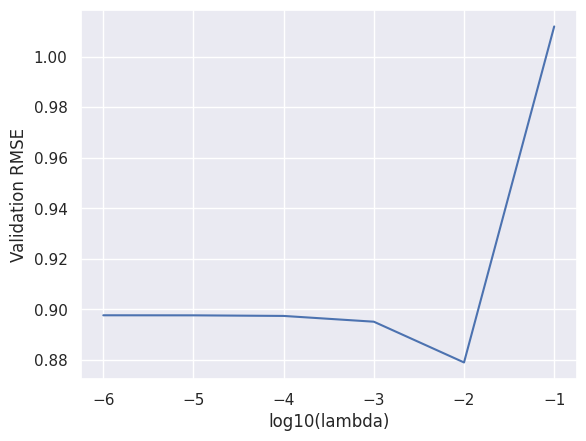

In [23]:
lambdas = 10.**torch.arange(-6,0,step=1,dtype=torch.float)
val_rmse = np.zeros(len(lambdas))
learning_rate = 0.001
for lbd_idx,lamb in enumerate(lambdas):
    print("Lambda=%f, fitting..." % lamb)
    beta, _ = fit_lasso(X_train, y_train, lamb, learning_rate = learning_rate)
    pred_val = X_val @ beta # make predictions on the validation set
    val_rmse[lbd_idx] = np.sqrt(torch.mean((y_val - pred_val)**2).item()) # item() gets the scalar value
_ = plt.plot(np.log10(lambdas.numpy()), val_rmse)
_ = plt.xlabel("log10(lambda)")
_ = plt.ylabel("Validation RMSE")

In [24]:
optimal_lamb = lambdas[np.argmin(val_rmse)]
optimal_lamb.item()

0.009999999776482582

gives optimal performance on the validation data.

Let's look at the distribution of fitted coefficients for the Lasso:

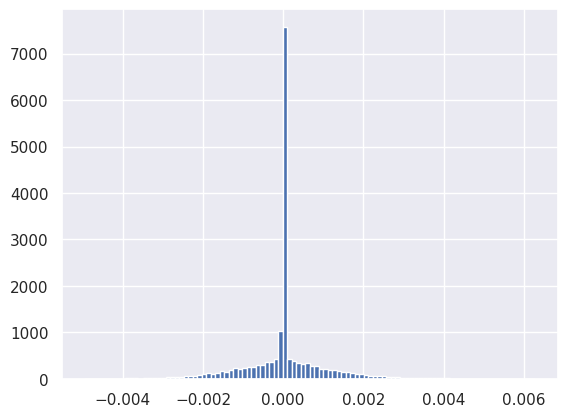

In [25]:
beta_lasso, _ = fit_lasso(X_train, y_train, lamb = optimal_lamb)
beta_lasso_np = beta_lasso.cpu().numpy()
_ = plt.hist(beta_lasso_np, 100)

Note that more coefficients are much more concentrated close to 0 than for the ridge regression.

Next let's look at predictions on the test set again:

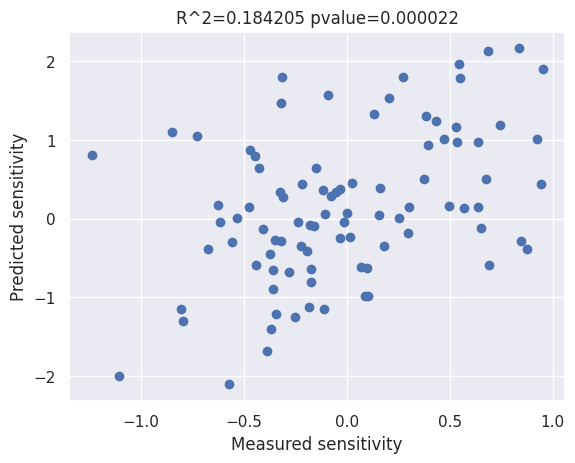

In [26]:
pred_test = X_test @ beta_lasso # make predictions on the test set
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())
plt.scatter(pred_test.cpu(), y_test.cpu())
plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

The R^2 (proportion of variance explained) is very similar for ridge and lasso regression, but the lasso is potentially more "interpretable" since it has fewer non-zero coefficients.

## Binary classification & Logistic regression

One of the analyses in the GDSC determined sensible thresholds to determine "resistant" vs "sensitive" cell lines for each drug. For PHI-7 the threshold is:

In [27]:
sens_threshold = 1.2307

Let's compare that to the distribution of IC50s.

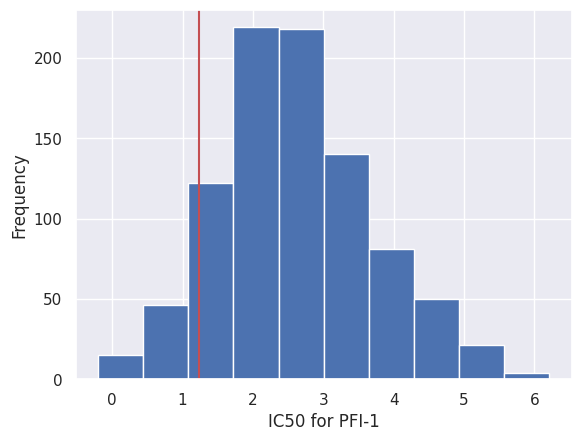

In [28]:
plt.hist(ic50["PFI-1"])
plt.xlabel("IC50 for PFI-1")
plt.ylabel("Frequency")
plt.axvline(x=sens_threshold, color='r')

So any cell lines with an IC50 < 1.23 would be considered sensitive, and >1.23 are resistant. Could we predict this binary outcome directly? We'll use logistic regression to do this. Unlike for linear regression we can't just subtract away the mean, so we'll need to include an intercept term. The easy way to do this is to add a column of `1`s to `X`.

In [29]:
X_train_1 = torch.cat((X_train, torch.ones((X_train.shape[0],1), device=device)), axis = 1)
X_val_1 = torch.cat((X_val, torch.ones((X_val.shape[0],1), device=device)), axis = 1)
X_test_1 = torch.cat((X_test, torch.ones((X_test.shape[0],1), device=device)), axis = 1)

In [30]:
y_binary = (y_unnorm < sens_threshold).float()
y_binary.mean().item()

0.09606987237930298

By this definition, 9% of the cell lines are sensitive.

In [31]:
y_bin_train = y_binary[train_idx]
y_bin_val = y_binary[val_idx]
y_bin_test = y_binary[test_idx]

**Now you'll write a function to evaluate the logistic regression loss and the gradient wrt `beta`**. You'll do this using [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) which is really use iteratively using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule). I've given the order of the things you need to calculate. The convention I'm using is that `dA_dB` is the partial derivative $\partial A / \partial B$. If you get an error you can call `%debug` in a subsequent cell to get the `pdb` debugger up. It can be useful to check the `shape` of tensors is correct (e.g. just `print` these). Note there are valid ways to do this that give dloss_dbeta as a [1xP] matrix but the code below expects a [P] vector (which you can get using torch.squeeze or dloss_dbeta[0,:]). A correct implementation will result in the assertion (two cells down) passing. [4 points]

In [32]:
def logistic_reg_loss_and_gradient(X, y, beta):
    # forward
    g = X @ beta
    p = torch.sigmoid(g)
    loss = - torch.mean( y * torch.log(p) + (1.-y) * torch.log(1.-p) )
    # backpropagation - TODO fill in the expressions
    dloss_dp = (1/len(y))*(-(y/p) + (1-y)/(1-p))# divide by the sample size to account for mean. shape [N]
    dp_dg = torch.sigmoid(g) * (1-torch.sigmoid(g))# You need to work out the derivative of the logistic function. Confirm this yourself! shape [N]
    dloss_dg = dp_dg* dloss_dp # chain rule! shape. [N]
    dg_dbeta = X # kinda trivial, just here for clarity. shape [N x P] (although the transpose which is [P x N] could be ok if used appropriately below)
    dloss_dbeta = dg_dbeta.transpose(0,1) @ dloss_dg # chain rule again, but using a matrix multiply! shape [P]
    return(loss, dloss_dbeta)

We aren't using it (yet) so that you can see how everything works explicitly, but one of the main features of `pytorch` and other DL libraries is that they can automatically calculate gradients via backprop for us. We can use this to check our hand-engineered gradient calculation:

In [33]:
beta = torch.zeros(X_train_1.shape[1], device=X.device, requires_grad = True) # requires_grad tells pytorch we want gradients for this tensor
loss,gradient_to_test = logistic_reg_loss_and_gradient(X_train_1, y_bin_train, beta)
loss.backward() # pytorch backprop
beta.grad # pytorch gradient

tensor([ 5.8106e-02, -1.6760e-04, -7.8512e-03,  ...,  3.4600e-03,
        -6.6840e-03,  3.9768e-01], device='cuda:0')

Check this matches with your hand-coded version:

In [34]:
assert( (beta.grad - gradient_to_test).abs().mean().item() < 1e-8 )

We want you to be able to run the remaining code even if you can't work out the backprop code above. So here's an implementation using `pytorch`s autograd:

In [35]:
def logistic_reg_loss_and_gradient(X, y, beta):
    beta.requires_grad = True # tell torch we will want gradients wrt to this
    if not beta.grad is None: beta.grad.zero_() # clear old gradient values from previous iterations
    g = X @ beta
    p = torch.sigmoid(g)
    loss = - torch.mean( y * torch.log(p) + (1.-y) * torch.log(1.-p) )
    loss.backward()
    beta.requires_grad = False # other it will try to track gradients during GD itself!
    return(loss, beta.grad)

Now we can use this function in gradient descent to fit the LR model. Notes
*   we include the option for both L1 and L2 regularization.
*   we initialize the intercept term to the MLE if all other coefficients were 0.
*   we don't regularize the intercept term.



In [36]:
 def fit_logistic_reg(X, y, l1_lambda = 0., l2_lambda = 0., learning_rate = 0.001, iterations = 100):
    beta = torch.zeros(X.shape[1], device=X.device)
    y_mean = y.mean()
    beta[-1] = torch.log(y_mean) - torch.log(1. - y_mean) # intercept init
    losses = []
    for it in range(iterations):
        loss, grad = logistic_reg_loss_and_gradient(X, y, beta)
        beta_no_int = beta[:-1] # beta excluding the intercept term at the end
        loss += l1_lambda * beta_no_int.abs().sum() + .5 * l2_lambda * (beta_no_int*beta_no_int).sum()
        losses.append(loss.item())
        grad[:-1] += l1_lambda * torch.sign(beta_no_int) + l2_lambda * beta_no_int # don't regularize intercept term
        if np.isnan(loss.item()):
            print("Warning: GD diverged at iteration %i" % it)
            return(beta * np.nan, losses) # return nan beta if diverges
        beta -= learning_rate * grad # * float(it+1)**-(2./3)
    return(beta,losses)

Let's try a range of L2 regularization and calculate the validation Negative Log Likelihood (nll).

Text(0, 0.5, 'Validation loss')

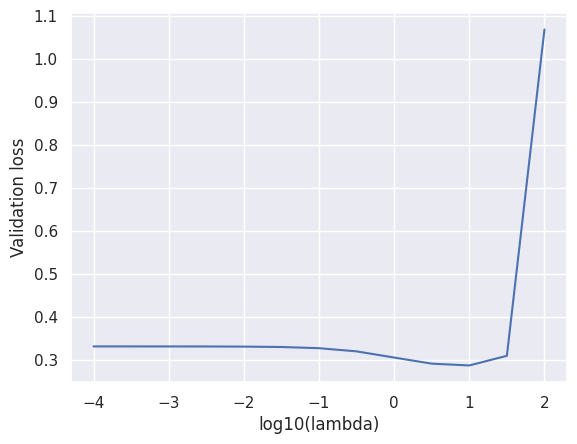

In [37]:
lambdas = 10 ** np.arange(-4, 4, step = 0.5)
val_nll = np.zeros_like(lambdas)

for i,lamb in enumerate(lambdas): # try different settings of lambda
    beta,_ = fit_logistic_reg( X_train_1, y_bin_train, l2_lambda = lamb, learning_rate = 0.01, iterations = 100 )
    pred_val = torch.sigmoid(X_val_1 @ beta) # make predictions on the validation set
    val_nll[i] = - torch.mean( y_bin_val * torch.log(pred_val) + (1.-y_bin_val) * torch.log(1.-pred_val) ).item() # item() gets the scalar value

plt.plot(np.log10(lambdas), val_nll)
plt.xlabel("log10(lambda)")
plt.ylabel("Validation loss")

Note that the optimization diverges for large values of lambda, we'll ignore this for now.

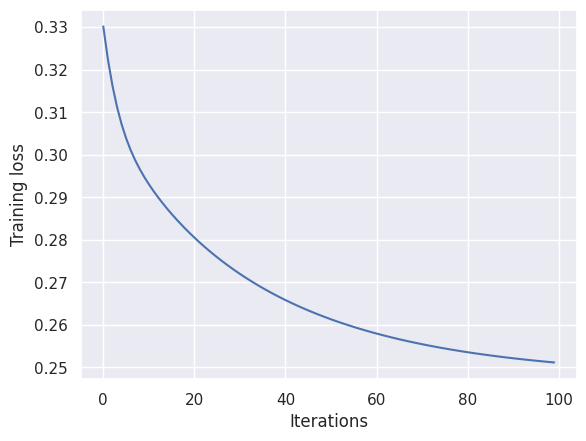

In [38]:
optimal_lamb = lambdas[np.nanargmin(val_nll)]
beta_logr,losses = fit_logistic_reg(X_train_1,
                                    y_bin_train,
                                    l2_lambda = optimal_lamb)
_ = plt.plot(losses)
_ = plt.xlabel("Iterations")
_ = plt.ylabel("Training loss")

Finally let's assess performance on the test data using a [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.

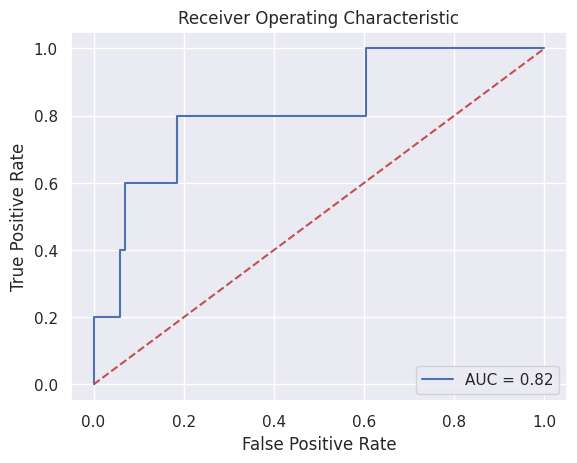

In [39]:
import sklearn.metrics as metrics
val_pred = torch.sigmoid(X_test_1 @ beta_logr)
fpr, tpr, _ = metrics.roc_curve(y_bin_test.cpu().numpy(), val_pred.cpu().numpy())
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random prediction gives an AUC of 0.5, so this is considerably better than that but still not great! This is a difficult prediction task!

## Neural networks

We'll use a Python class to hold the multiple parameters (weight matrices and intercepts) that make up the neural network. This also lets us conviently encapsulate associated functions to calculate the loss and gradient and to perform GD.

**You'll implement backprop again following a recipe as above for logistic regression. [4 points]**

I strongly recommend drawing out the computation graph for one layer and working out the math by hand before you start trying to code this!

Note that variables called e.g. `dloss_dA` refers to $\frac{\partial L}{\partial A}$ and should have the same shape as `A`.

In [40]:
class DNN:

    def __init__(self, dims, device, requires_grad = False):
        """Initialize Dense Neural Network

        Parameters
        ----------
        dims : array-like
            Array specifying number of neurons in (i.e. dimension of) each layer.
            dims[0] is the input dimension, last element dims[-1] is the output dimension. The
            number of hidden layers is len(dims)-1.
        device
            The torch device to use.
        requires_grad : bool
            Set to true to check calculations against pytorch's own autograd
            (or to False to save
        """
        self.weights = {}
        self.intercepts = {}
        self.num_hidden_layers = len(dims) - 2 # dims[0] = input dim,
        self.dloss_dweights = {}
        self.dloss_dintercept = {}
        for layer_idx in range(len(dims)-1):
            self.weights[layer_idx] = torch.randn(dims[layer_idx:layer_idx+2],
                                                  device=device) * np.sqrt(2. / dims[layer_idx])  # He initialization
            if requires_grad:
                self.weights[layer_idx].requires_grad = True
            self.intercepts[layer_idx] = torch.zeros(dims[layer_idx+1],
                                                     device=device,
                                                     requires_grad = requires_grad)

    def loss_and_gradient(self, X, y, obs_weights, backprop = True):
        hidden = {} # dictionary to store activations/outputs of each layer. hidden[i] = output of layer i
        hidden[-1] = X # use hidden[-1] to denote the model input X
        # forward
        for layer_idx in range(self.num_hidden_layers + 1):
            g = hidden[layer_idx - 1] @ self.weights[layer_idx] + self.intercepts[layer_idx]
            hidden[layer_idx] = torch.relu(g) if (layer_idx < self.num_hidden_layers) else g # don't run ReLU on output layer
        output = hidden[self.num_hidden_layers] # output of final layer is the DNN output
        err = y - output
        loss = .5 * torch.sum(obs_weights * err * err) / obs_weights.sum()

        # backpropagation
        if backprop:
            dloss_dhidden = {}
            dloss_dhidden[self.num_hidden_layers] = - obs_weights * err / obs_weights.sum() # remember hidden[self.num_hidden_layers] is the model output
            for layer_idx in range(self.num_hidden_layers, -1, -1): # iterate backwards through each layer
                if layer_idx < self.num_hidden_layers:
                    dloss_dg = dloss_dhidden[layer_idx]*(hidden[layer_idx] > 0)
                else:
                    dloss_dg = dloss_dhidden[layer_idx] # for the output layer g == output
                assert(dloss_dg.shape == hidden[layer_idx].shape)
                self.dloss_dweights[layer_idx] = hidden[layer_idx-1].transpose(0,1) @ dloss_dg
                assert(self.dloss_dweights[layer_idx].shape == self.weights[layer_idx].shape)
                self.dloss_dintercept[layer_idx] = dloss_dg.sum(axis = 0) # could do this with chain rule, but there's a more efficient way
                assert(self.dloss_dintercept[layer_idx].shape == self.intercepts[layer_idx].shape)
                dloss_dhidden[layer_idx - 1] = dloss_dg @ self.weights[layer_idx].transpose(0,1) # chain rule and recurse back to next layer. input of this layer is the output of the previous layer
                assert(dloss_dhidden[layer_idx - 1].shape == hidden[layer_idx - 1].shape)

        return(loss,output) # g is the final network output

    def grad_step(self, X, y, obs_weights, learning_rate = 0.001):
        loss,_ = self.loss_and_gradient(X, y, obs_weights)
        for layer_idx in range(self.num_hidden_layers + 1):
            self.weights[layer_idx] -= learning_rate * self.dloss_dweights[layer_idx]
            self.intercepts[layer_idx] -= learning_rate * self.dloss_dintercept[layer_idx]
        return(loss)

    def cache_parameters(self):
        self.cached_weights = { k:v.detach().clone() for k,v in self.weights.items() }
        self.cached_intercepts = { k:v.detach().clone() for k,v in self.intercepts.items() }

    def recover_cache(self):
        self.weights = self.cached_weights
        self.intercepts = self.cached_intercepts

    def gradient_descent(self, X, y, obs_weights, X_val, y_val, obs_weights_val, iterations = 100, learning_rate = 0.001):
        losses = []
        val_losses = []
        patience = 10 # for early stopping
        patience_counter = patience
        best_val_loss = np.inf
        for it in range(iterations):
            loss = self.grad_step(X, y, obs_weights, learning_rate = learning_rate)
            losses.append(loss.item())
            val_loss,_ = self.loss_and_gradient(X_val, y_val, obs_weights_val, backprop = False)
            val_losses.append(val_loss.item())
            if val_loss < best_val_loss:
                self.cache_parameters()
                best_val_loss = val_loss
                patience_counter = patience
            else:
                patience_counter -= 1
                if patience_counter <= 0:
                    print("Early stopping at iteration %i" % it)
                    self.recover_cache() # recover the best model so far
                    break
        return(losses,val_losses)

Let's check our calculation against `pytorch`:

In [41]:
dnn = DNN([X.shape[1], 16, 1], device = device, requires_grad=True)
loss,_ = dnn.loss_and_gradient(X_train, y_train[:,None], torch.ones_like(y_train[:,None]))
loss.backward()
assert( ( dnn.dloss_dweights[0] - dnn.weights[0].grad ).abs().mean().item() < 1e-8 )

Make sure this assertion passes! In case you really can't figure out the backprop math/code here's a version of loss_and_gradients you can substitute into the class definition above which which uses `pytorch`'s builtin backprop abilities rather than coding it manually:

In [42]:
def loss_and_gradient(self, X, y, obs_weights, backprop = True):

    if backprop:
        for layer_idx in range(self.num_hidden_layers + 1):
            self.weights[layer_idx].requires_grad = True
            self.intercepts[layer_idx].requires_grad = True
            if not self.weights[layer_idx].grad is None: self.weights[layer_idx].grad.zero_()
            if not self.intercepts[layer_idx].grad is None: self.intercepts[layer_idx].grad.zero_()

    hidden = {} # dictionary to store activations/outputs of each layer. hidden[i] = output of layer i
    hidden[-1] = X # use hidden[-1] to denote the model input X
    # forward
    for layer_idx in range(self.num_hidden_layers + 1):
        g = hidden[layer_idx - 1] @ self.weights[layer_idx] + self.intercepts[layer_idx]
        hidden[layer_idx] = torch.relu(g) if (layer_idx < self.num_hidden_layers) else g # don't run ReLU on output layer
    output = hidden[self.num_hidden_layers] # output of final layer is the DNN output
    err = y - output
    loss = .5 * torch.sum(obs_weights * err * err) / obs_weights.sum()

    if backprop:
        # backpropagation
        loss.backward(retain_graph=True)
        for layer_idx in range(self.num_hidden_layers + 1):
            self.weights[layer_idx].requires_grad = False
            self.intercepts[layer_idx].requires_grad = False
            self.dloss_dweights[layer_idx] = self.weights[layer_idx].grad
            self.dloss_dintercept[layer_idx] = self.intercepts[layer_idx].grad

    return(loss,output.detach())

OK let's try to fit our first NN!

Early stopping at iteration 59


Text(0, 0.5, 'MSE Loss')

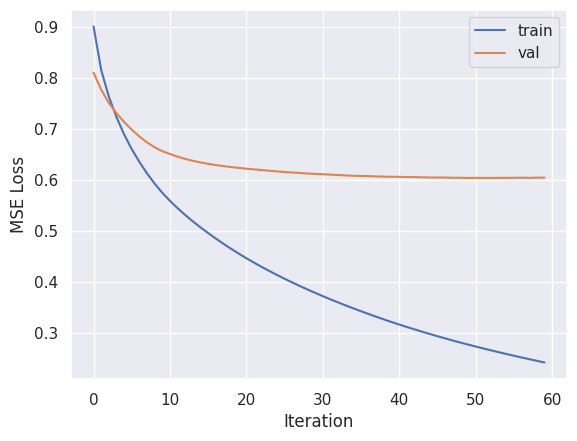

In [43]:
dnn = DNN([X.shape[1], 16, 1], device = device, requires_grad=False)
losses,val_losses = dnn.gradient_descent(X_train,
                                         y_train[:,None],
                                         torch.ones_like(y_train[:,None]),
                                         X_val,
                                         y_val[:,None],
                                         torch.ones_like(y_val[:,None]))
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")

A common strategy in DL is [early stopping](https://en.wikipedia.org/wiki/Early_stopping) where we stop (S)GD when the performance on the validation data stops improving. This is an implicit form of regularization in contrast with the explicit L1 and L2 regularization terms we used for linear/logistic regression.

Let's check predictive performance on the test set.

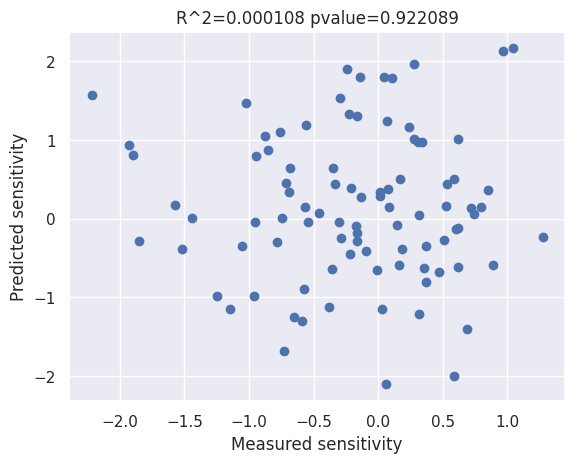

In [44]:
test_loss,pred_test = dnn.loss_and_gradient(X_test, y_test[:,None], torch.ones_like(y_test[:,None]))
pred_test = pred_test.flatten() # remove spurious extra dimension
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())
plt.scatter(pred_test.cpu(), y_test.cpu())
plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

Here the DNN predicts better than random ($p<0.05$) on the test set, but worse than ridge or lasso regression. Why might that be (in general or for this application in particular)? (Give two reasons) [2 points]

1) Due to having a large # of parameters, DNNs can often lead to overfitting, especially with small datasets or high-dimensional data (where P >> N). However, ridge and lasso regression use regularization that allows direct control over overfitting and reduces the effective number of parameters.

2) The dataset size may not be big enough to train a neural network to be generalized well. NNs generally require a large scale of data to find patterns without overfitting. Therfore with a smaller dataset, simpler linear models like ridge or lasso regression can often perform better by fitting a less number of parameters.

What could you try to improve the DNN's performance? (Give two suggestions) [2 points]

1) Changing the number of hidden layers and neurons to find an optimal balance between underfitting/overfitting. A simpler model could help reduce the tendency to overfit, while tuning hyperparameters (e.g learning rate, batch size) can help improve performance.

2) By increasing the size of the training dataset size or using data augmentation, we can provide more examples for DNN to learn to learn patterns that could be generalized, which would likely improve performance and reduce overfitting.

Implement one of your ideas. [2 points]

Text(0, 0.5, 'MSE Loss')

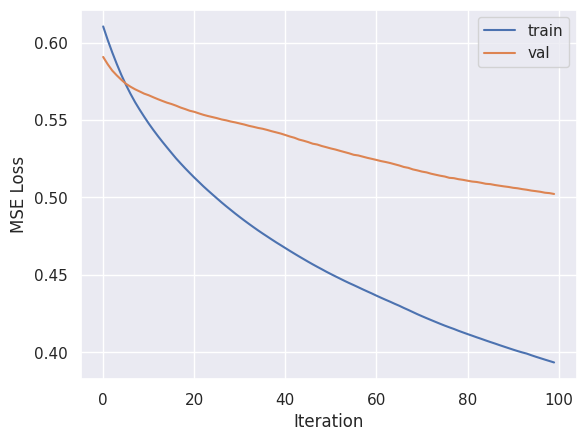

In [45]:
my_dnn = DNN([X.shape[1],4,3,2,1], device = device, requires_grad=False)
losses,val_losses = my_dnn.gradient_descent(X_train,
                                          y_train[:,None],
                                          torch.ones_like(y_train[:,None]),
                                          X_val,
                                          y_val[:,None],
                                          torch.ones_like(y_val[:,None]))
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")

Does it seem to improve the performance? Credit here will just be for assessing this (for at least one random initalization), not for actually improving performance (because different initializations have a substantial effect). [1 point]

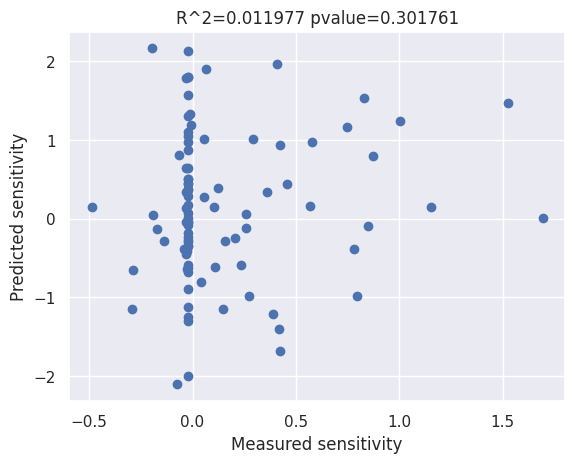

In [46]:
test_loss,pred_test = my_dnn.loss_and_gradient(X_test, y_test[:,None], torch.ones_like(y_test[:,None]))

pred_test = pred_test.flatten() # remove spurious extra dimension
R,p = scipy.stats.pearsonr(y_test.cpu(), pred_test.cpu())
plt.scatter(pred_test.cpu(), y_test.cpu())
plt.title("R^2=%f pvalue=%f" % (R**2, p))
plt.xlabel("Measured sensitivity")
plt.ylabel("Predicted sensitivity")
plt.show()

Performance has increased from 0.114063 to 0.083427, but only very slightly.

## Multitask prediction

Neural networks naturally allow multitask prediction. We'll want to preprocess the data a little differentally for this, including cell lines where <50% of the IC50 values are missing and drugs where <40% is missing.

First let's select the cell lines to keep:

905

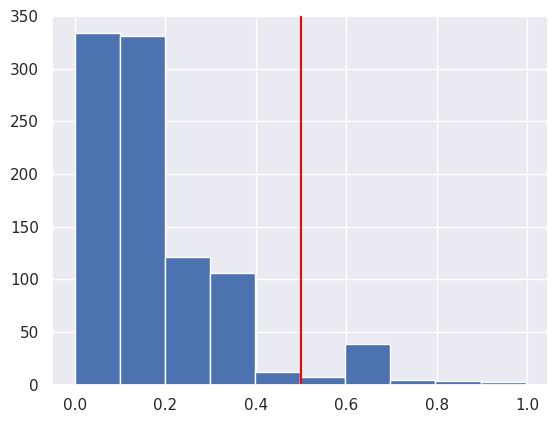

In [47]:
ic50_np = ic50.iloc[:,1:].to_numpy()
miss = np.isnan(ic50_np)
prop_miss_cell = miss.mean(1)
cell_to_keep = prop_miss_cell < 0.5
plt.hist(prop_miss_cell)
plt.axvline(0.5, color = "red")
cell_to_keep.sum()

905 cell lines are included. Now we'll select the drugs to keep:

217

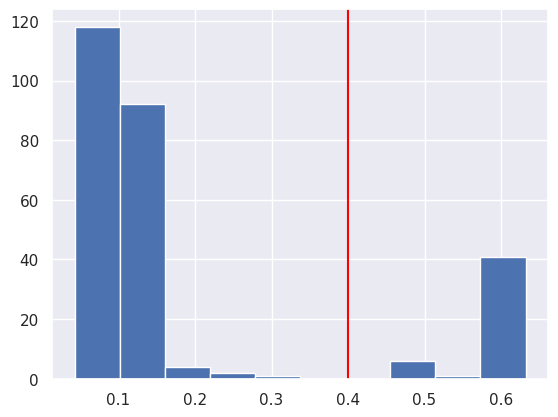

In [48]:
prop_miss_drug = miss.mean(0)
drug_to_keep = prop_miss_drug < 0.4
plt.hist(prop_miss_drug)
plt.axvline(0.4, color = "red")
drug_to_keep.sum()

217 drugs are included. We'll normalize the data as before, also keeping track of which elements of `y` are missing through `obs_weight` (1=not missing, 0=missing).###

In [49]:
y_all = ic50_np[np.ix_(cell_to_keep, drug_to_keep)]
obs_weight = torch.tensor(~np.isnan(y_all), device = device, dtype = torch.float) # nan values = missing
y_all[np.isnan(y_all)]=0. # set to 0 since these points will be ignored anyway by the masking
y_unnorm = torch.tensor(y_all, device = device, dtype = torch.float)
y_mt = (y_unnorm - y_unnorm.mean(0, keepdims=True)) / y_unnorm.std(0, keepdims=True) # normalize

X_unnorm = torch.tensor(X_all[cell_to_keep,:], device = device, dtype = torch.float)
X_mt = (X_unnorm - X_unnorm.mean(0, keepdims=True)) / X_unnorm.std(0, keepdims=True)

Train, test & validation split again:  

In [50]:
N = y_mt.shape[0]

np.random.seed(1) # for reproducibility
rand_perm = np.random.permutation(N)
train_idx = rand_perm[:int(np.ceil(0.8 * N))]
val_idx = rand_perm[int(np.ceil(0.8 * N)):int(np.ceil(0.9 * N))]
test_idx = rand_perm[int(np.ceil(0.9 * N)):]

X_mt_train = X_mt[train_idx,:]
X_mt_val = X_mt[val_idx,:]
X_mt_test = X_mt[test_idx,:]

y_mt_train = y_mt[train_idx,:]
y_mt_val = y_mt[val_idx,:]
y_mt_test = y_mt[test_idx,:]

obs_weight_train = obs_weight[train_idx,:]
obs_weight_val = obs_weight[val_idx,:]
obs_weight_test = obs_weight[test_idx,:]

Let's try training with 64 hidden units. Here we're training one model that outputs predictions for every drug, so we want y_mt.shape[1]==217 output dimensions.

Early stopping at iteration 786


1.1250030994415283

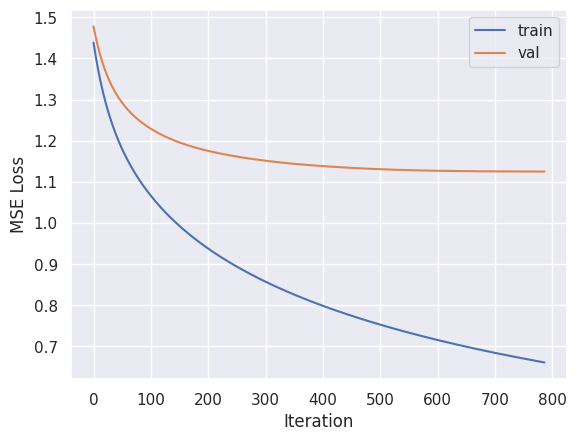

In [51]:
dnn_mt = DNN([X_mt.shape[1], 64, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = dnn_mt.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
min(val_losses)

Let's get the test set MSE as well:

In [52]:
test_loss,_ = dnn_mt.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
test_loss.item()

1.0807912349700928

How does this do compare to two hidden layers with 32 units each?

0.7741784453392029

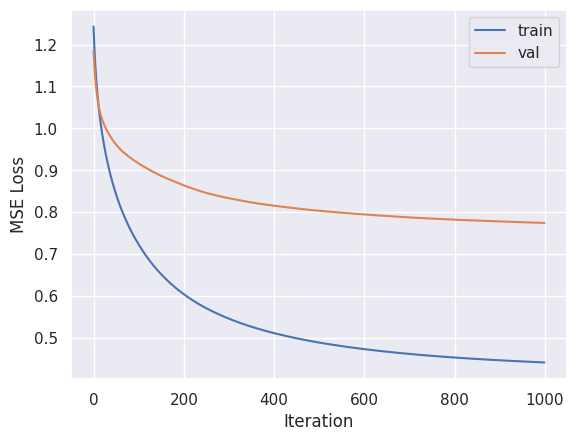

In [53]:
dnn_mt_2 = DNN([X_mt.shape[1], 32, 32, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = dnn_mt_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)
plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
min(val_losses)

In [54]:
test_loss,_ = dnn_mt_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
test_loss.item()

0.7439289689064026

The two layer model tends to do better than the wider one layer model.

*Try playing with the depth and width of the network to get the best performance you can. Write up your findings including plotting performance vs depth or performance vs width* [4 points].

## Extra exercises

1.   At this modest data scale it would be better to do (e.g. 10-fold) [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)), with a final held-out test set. Implement this for the L1 regularized regression: do you get similar optimal lambda as with the single validation hold out? [2 points extra credit]
2.   Is multitask prediction better than single-task? Fit a per drug model for each drug (i.e. 217 different models each with one output only) using the same train/validation/ test split as for the multitask training and compare the performance in terms of MSE loss. (if this is too slow to train you can try on just a subset of 20 of the drugs). [2 points extra credit]



In [112]:
loss_mine = []

my_dnn_2 = DNN([X.shape[1],4, y_mt.shape[1]], device = device, requires_grad=False)

losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

Early stopping at iteration 51


In [113]:
my_dnn_2 = DNN([X.shape[1],4,4, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

Early stopping at iteration 51


In [114]:
my_dnn_2 = DNN([X.shape[1],4,4,4,y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

Early stopping at iteration 347


In [115]:
my_dnn_2 = DNN([X.shape[1],4,4,4,4,y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

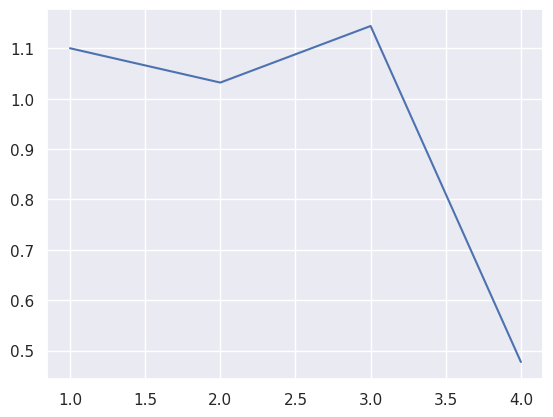

In [116]:
plt.plot([1,2,3,4], loss_mine)


The performance deacreases as depth increases from 1 to 2, but then increases from depth 2 to 3. Then sharply decreases for depth 3 to 4. The simpler the model, we can see that the loss is very high due to inability to learn the relationship within the data. As we increase the number of layers, the testing loss decreases sharply.

In [129]:
loss_mine = []

my_dnn_2 = DNN([X.shape[1],1,1,1,y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

In [130]:

my_dnn_2 = DNN([X.shape[1],2,2,2, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

In [131]:

my_dnn_2 = DNN([X.shape[1],3,3,3, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

Early stopping at iteration 299


In [132]:
my_dnn_2 = DNN([X.shape[1],4,4,4, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

Early stopping at iteration 244


In [133]:
my_dnn_2 = DNN([X.shape[1],5,5,5, y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

test_loss,_ = my_dnn_2.loss_and_gradient(X_mt_test, y_mt_test, obs_weight_test)
loss_mine.append(test_loss.item())

Early stopping at iteration 38


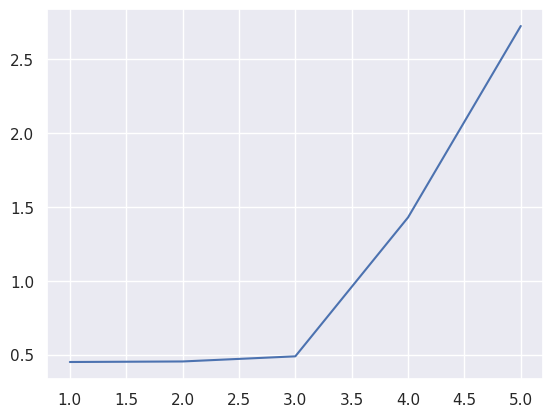

In [134]:
plt.plot([1,2,3,4,5], loss_mine)

As the number of neurons per layer increases from 1 to 3, the test performance remains constant but as the number of neurons per layer increases from 3 to 5, the test performance increases sharply.

0.4272444248199463

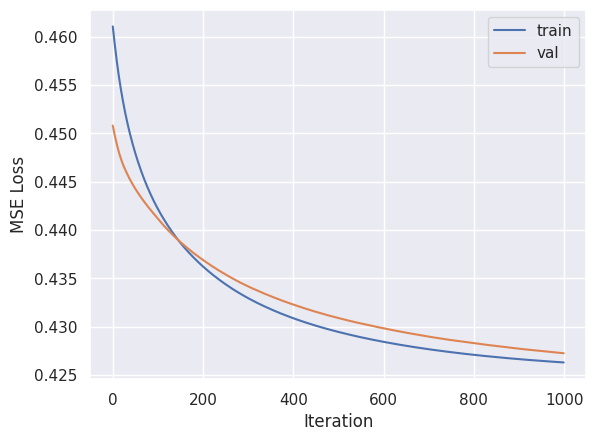

In [144]:
my_dnn_2 = DNN([X.shape[1],3,3,3,3,y_mt.shape[1]], device = device, requires_grad=False)
losses,val_losses = my_dnn_2.gradient_descent(X_mt_train,
                                         y_mt_train,
                                         obs_weight_train,
                                         X_mt_val,
                                         y_mt_val,
                                         obs_weight_val,
                                         iterations = 1000)

plt.plot(losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
min(val_losses)